<a href="https://colab.research.google.com/github/Samuebar/playground_thesis/blob/main/Copy_of_CMAPSS_Dataset_DS02_SL_1dCNN_tf2_final_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMAPSS Dataset DS02 - SL-1dCNN -tf2


Please run the following cell to load all the packages required in this notebook. 

In [ ]:
import h5py
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import gridspec
from operator import itemgetter
from time import gmtime, strftime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')# force_remount=True

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/prognostics/models/

/content/drive/.shortcut-targets-by-id/157PRjqs3VYYkcgOtzYoxjpqQg4azYuXZ/prognostics/models


**Auxiliary plotting functions:**

In [ ]:
def plot_variables(data, figsize=10, option='idx', labelsize=16):
    """
    """
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))       
    
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        # Plot only units lines
        for jj in data[0]['ds_name']:
            ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], markeredgewidth=0.25, markersize=8)
                          
        # Adjusments
        if (y_min !=None) & (y_max !=None):
            ax.set_ylim(y_min, y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(data[0]['label'][n], fontsize=labelsize)
        
        # Labels and legend
        if option=='idx':
            plt.xlabel('Time [t]', fontsize=labelsize)
        else:
            plt.xlabel('Time [cycles]', fontsize=labelsize)    
        plt.legend(data[0]['legend'], fontsize=labelsize-2, loc='lower left')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
def plot_kdeplot(leg, variables, labels, size, *args):
    """
    """
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 2': 'C3', 'Unit 5': 'C4', 'Unit 10': 'C5', 'Unit 16': 'C6', 'Unit 18': 'C7', 'Unit 20': 'C8',
                      'Unit 11': 'C0', 'Unit 14': 'C1', 'Unit 15': 'C2', 'Training': 'k'} 
    
    fig  = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k in range(int(len(args))):
            sns.kdeplot(args[k][variables[n]], color=color_dic_unit[leg[k]], shade=True, gridsize=300) # 
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
        plt.xlabel(labels[n], fontsize=16)
        plt.ylabel('Density [-]', fontsize=16)
        plt.legend(leg, fontsize=15, loc='upper left')
    plt.tight_layout()
    plt.savefig('kde3')
    plt.show()
    plt.close()
    
    
def plot_rul_scenarios(unit_sel, log_rul_path_gen, U_test, C_test, leg):
    """
    """
    for j in unit_sel:
        fig = plt.figure() # figsize=(9, 7)
        for i in range(len(log_rul_path_gen)):
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = U_test == j  
            c_gen = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_gen = log_rul_path_gen[i][unit]
            y_hat_gen_sorted = y_hat_gen[idx]
            for k in np.unique(c_gen):
                y_hat_mean.append(np.mean(y_hat_gen_sorted[c_gen == k]))
                y_hat_max.append(np.max(y_hat_gen_sorted[c_gen == k]))
                y_hat_min.append(np.min(y_hat_gen_sorted[c_gen == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_gen), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_gen), y_hat_min, y_hat_max, alpha=0.3)
        #plt.gca().set_prop_cycle(None)
        print('Unit:', str(j))


        c_gen_unique = np.unique(np.sort(C_test[unit])-1)
        #plt.plot(c_gen_unique, c_gen_unique[::-1]-40, alpha=0.7)
        plt.plot(c_gen_unique, np.zeros(len(c_gen_unique)),'r', alpha=0.7)

        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Predicted $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        #plt.ylim(top=90)


def plot_results(OUTFOLDER, label_, log_y_hat_test, unit_sel, Y_test, Unit_test, C_test):
    """
    """   
    # Set-up
    base = np.array([0.0, 80.0])
   
    # True and predict vs time - Test Per engine
    for i in range(len(log_y_hat_test)):
        fig = plt.figure()
        leg = []
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j  
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_test), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_test), y_hat_min, y_hat_max, alpha=0.3)
            leg.append('Unit ' + str(j))
        plt.gca().set_prop_cycle(None)
        for j in unit_sel:        
            unit = Unit_test == j  
            c_test_unique = np.unique(np.sort(C_test[unit])-1)
            plt.plot(c_test_unique, c_test_unique[::-1], alpha=0.7)
            leg.append('True-Unit ' + str(j))
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Predicted & True $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=90)
        plt.savefig(OUTFOLDER + 'rul_vs_time_model_' + label_ + '_' + str(i) + '.png', format='png', dpi=300)    
        
    # Error: True - predict - Test Per engine
    for i in range(len(log_y_hat_test)):
        fig = plt.figure()
        leg = []
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            c_test_unique = np.unique(c_test)
            for k in c_test_unique:
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
        
            unit = Unit_test == j  
            plt.plot(c_test_unique, y_hat_mean-c_test_unique[::-1], '-o', alpha=0.7)
            plt.fill_between(c_test_unique, y_hat_min-c_test_unique[::-1], y_hat_max-c_test_unique[::-1], alpha=0.3)
            leg.append('Unit ' + str(j))
        plt.plot(base, [5, 5], 'r-.', linewidth=1)
        plt.plot(base, [0.0, 0.0], 'r-', linewidth=2)
        plt.plot(base, [-5, -5], 'r-.', linewidth=1)
        leg.append(r'$\epsilon=$ $\pm$ 5')
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Error $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=20)
        plt.ylim(bottom=-20)
        plt.savefig(OUTFOLDER + 'rul_error_vs_time_model_' + label_ + '_' + str(i) + '.png', format='png', dpi=300)
    
    # Avg. score vs time - Test
    for i in range(len(log_y_hat_test)):
        leg = []
        score_cycle = []
        rmse_cycle = []
        C_test_unique = np.unique(C_test)
        y_hat_test = log_y_hat_test[i]
        for k in C_test_unique:
            score_cycle.append(score_cal(y_hat_test[C_test <= k], Y_test[C_test <= k])*100000)
            rmse_cycle.append(np.sqrt(np.mean((y_hat_test[C_test <= k] - Y_test[C_test <= k])**2)))
        score_cycle = np.array(score_cycle, dtype=np.float64)
        mse_cycle = np.array(rmse_cycle, dtype=np.float64)
        
        # Plot
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('Time [cycles]')
        ax1.set_ylabel(r'RMSE [-]', color=color)
        lns1 = ax1.plot(mse_cycle, '.', color=color, label='RMSE')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_ylim((3.9, 11.1))
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:blue'
        ax2.set_ylabel(r'Score - $s$ [-]', color=color)  # we already handled the x-label with ax1
        lns2 = ax2.plot(score_cycle, color=color, label='Score')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.ticklabel_format(style='sci', scilimits=(0,3))
        ax2.set_ylim((0, 1.4e5))
        
        lns = lns1 + lns2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc='upper left')
        
        #plt.legend(leg, loc='best')
        plt.savefig(OUTFOLDER + 'score_vs_time_test_' + label_ + '_' + str(i) + '.png', format='png', dpi=300)


**Auxiliary evaluation functions:**

In [ ]:
def score_cal(y_hat, Y_test):
    """
    """
    d = y_hat - Y_test
    d.ravel()
    score = []
    for i in range(d.shape[0]):
        if d[i] >= 0:
            score.append(np.exp(d[i]/10) - 1)
        else:
            score.append(np.exp(-d[i]/13) - 1)
    return np.sum(np.array(score))/100000

def predict_time(MODEL_PATH, varInput, log_y_hat_test, unit_sel, Unit_test, C_test, max_d=5):
    """
    """
    # Set-up
    log_d = []
    df_results, df_results_m, df_results_q = DataFrame(), DataFrame(), DataFrame()
    for i in range(len(log_y_hat_test)):
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min, y_hat_q975, y_hat_q025 = [], [], [], [], []
            unit = Unit_test == j
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
                y_hat_q975.append(np.percentile(y_hat_test_sorted[c_test == k], 97.5))
                y_hat_q025.append(np.percentile(y_hat_test_sorted[c_test == k], 2.5))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            y_hat_q975 = np.array(y_hat_q975, dtype=np.float64)
            y_hat_q025 = np.array(y_hat_q025, dtype=np.float64)
        
            c_test_unique = np.unique(c_test)
            
            # Mean
            epsilon_y = np.abs(y_hat_mean-c_test_unique[::-1])
            mask = np.ravel(epsilon_y >= max_d)            
            df_results.loc[i, 'Unit ' + str(j)] = c_test_unique[mask][-1]
            
            # Max
            epsilon_y_max = np.abs(y_hat_max-c_test_unique[::-1])
            epsilon_y_min = np.abs(y_hat_min-c_test_unique[::-1])
            epsilon_max = np.max([epsilon_y_max, epsilon_y_min], axis=0)
            mask_m = np.ravel(epsilon_max >= max_d)            
            df_results_m.loc[i, 'Unit ' + str(j)] = c_test_unique[mask_m][-1]

            # 95% confidence
            epsilon_y_q975 = np.abs(y_hat_q975-c_test_unique[::-1])
            epsilon_y_q025 = np.abs(y_hat_q025-c_test_unique[::-1])
            epsilon_q95 = np.max([epsilon_y_q975, epsilon_y_q025], axis=0)
            mask_q = np.ravel(epsilon_q95 >= max_d)            
            df_results_q.loc[i, 'Unit ' + str(j)] = c_test_unique[mask_q][-1]


    # Write solutions to external file
    df_results.to_csv(MODEL_PATH + 'Time_epsilon_mean_' + varInput + '.csv')
    df_results_m.to_csv(MODEL_PATH + 'Time_epsilon_max-min_' + varInput + '.csv')
    df_results_q.to_csv(MODEL_PATH + 'Time_epsilon_q95_' + varInput + '.csv')
            
    return df_results, df_results_m, df_results_q
    

**Auxiliary processing functions:**

In [ ]:
from tensorflow.python.ops import math_ops   
from tensorflow.python.ops import array_ops   
from tensorflow.python.data.ops import dataset_ops

def timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
 
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                         'time steps (axis 0) but got '
                         'shape(data) = %s; shape(targets) = %s.' %
                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                         'length of the data. Got: start_index=%s '
                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                             'start_index=%s, end_index=%s.' %
                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                             'Got: end_index=%s' % (end_index,))
    
    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
          'sampling_rate must be higher than 0 and lower than '
          'the length of the data. Got: '
          'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
          'sequence_stride must be higher than 0 and lower than '
          'the length of the data. Got: sequence_stride=%s '
          'for data of length %s.' % (sequence_stride, len(data)))
    
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)
     
    # Determine the lowest dtype to store start positions (to lower memory usage).
    num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'
    
    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)
    
    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)
    
    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()
    
    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
        (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: math_ops.range(  # pylint: disable=g-long-lambda
                positions[i],
                positions[i] + sequence_length * sampling_rate,
                sampling_rate),
            num_parallel_calls=dataset_ops.AUTOTUNE)
    
    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
          (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
              lambda i, positions: positions[i] + (sequence_length-1) * sampling_rate,
              num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
          targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
      # Shuffle locally at each iteration
      dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    return dataset

def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: array_ops.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

from tensorflow.python.util import nest
from tensorflow.python.ops import sparse_ops
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.framework import sparse_tensor
from tensorflow.python.ops.ragged import ragged_tensor
from tensorflow.python.ops.ragged import ragged_concat_ops

def concat(tensors, axis=0):
    """Concats `tensor`s along `axis`."""
    if isinstance(tensors[0], sparse_tensor.SparseTensor):
        return sparse_ops.sparse_concat_v2(axis=axis, sp_inputs=tensors)
    if isinstance(tensors[0], ragged_tensor.RaggedTensor):
        return ragged_concat_ops.concat(tensors, axis=axis)
    return array_ops.concat(tensors, axis=axis)

def from_batchdataset_to_nparray(dataset):
    outputs = None
    for batch in dataset:
        batch_inputs, batch_outputs = batch
        if outputs is None:
            outputs = nest.map_structure(lambda batch_output: [batch_output],
                                       batch_outputs)
        else:
            nest.map_structure_up_to(
              batch_outputs,
              lambda output, batch_output: output.append(batch_output),
              outputs, batch_outputs)
    all_outputs = nest.map_structure_up_to(batch_outputs, concat, outputs)
    return tf_utils.to_numpy_or_python_type(all_outputs)

def extract_units(id_en, W_train, X_train, Y_train, U_train, C_train, T_train):
    
    # Set-up
    W_sub, X_sub, Y_sub, U_sub, C_sub, T_sub = [], [], [], [], [], []
    U_unique = np.unique(U_train)

    # Process
    for i in U_unique:
        if i in id_en:
            idx = np.ravel(U_train==i)
            W_sub.append(W_train[idx,:])           
            X_sub.append(X_train[idx,:])
            Y_sub.append(Y_train[idx,:])
            U_sub.append(U_train[idx,:])
            C_sub.append(C_train[idx,:])
            T_sub.append(T_train[idx,:])

    W_sub = np.concatenate(W_sub, axis=0)
    X_sub = np.concatenate(X_sub, axis=0)
    Y_sub = np.concatenate(Y_sub, axis=0)
    U_sub = np.concatenate(U_sub, axis=0)
    C_sub = np.concatenate(C_sub, axis=0)
    T_sub = np.concatenate(T_sub, axis=0)
    
    return W_sub, X_sub, Y_sub, U_sub, C_sub, T_sub

def extract_units_ds(id_en, ds, units):
    '''
    Creates a subset with only id_en units for ds
    '''
    
    # Set-up
    ds_sub = []
    units_unique = np.unique(units)

    # Process
    for i in units_unique:
        if i in id_en:
            idx = np.ravel(units==i)
            ds_sub.append(ds[idx,:])           
    
    return np.concatenate(ds_sub, axis=0)

def slider_fn_3(input_data, targets, units, sequence_length=1, sequence_stride=1, sampling_rate=1):
    """
     # Generates dataset with windows of sequence_length      
    """          
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        if i==0:
            dataset = timeseries_dataset_from_array(
                          input_data[mask], targets[mask], 
                          sequence_length=sequence_length,
                          sequence_stride=sequence_stride,
                          sampling_rate=sequence_stride)
        else:
            dataset = dataset.concatenate(timeseries_dataset_from_array(
                          input_data[mask], targets[mask], 
                          sequence_length=sequence_length,
                          sequence_stride=sequence_stride,
                          sampling_rate=sequence_stride))
    return dataset


## Load Training and Test Data

In [ ]:
TEST = '../data'
PATH_IN = TEST
SOURCE = 'CMAPSS_Dataset_DS02_Journal_v2'

#def load_data(PATH_IN, SOURCE)
 
# Time tracking, Operation time (min):  0.004
t = time.process_time()

with h5py.File(PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Training set
    W_train = np.array(hdf.get('W_train'))                 # W
    X_s_train = np.array(hdf.get('X_s_train'))             # X_s
    X_v_train = np.array(hdf.get('X_v_train'))             # X_v
    T_train = np.array(hdf.get('T_train'))                 # T
    Y_train = np.array(hdf.get('Y_train'))                 # RUL  
    U_train = np.array(hdf.get('U_train'))                 # Units
    C_train = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                   # W
    X_s_test = np.array(hdf.get('X_s_test'))               # X_s
    X_v_test = np.array(hdf.get('X_v_test'))               # X_v
    T_test = np.array(hdf.get('T_test'))                   # T
    Y_test = np.array(hdf.get('Y_test'))                   # RUL  
    U_test = np.array(hdf.get('U_test'))                   # Units
    C_test = np.array(hdf.get('C_test'))                   # Cycles

# Bias - Train
    T_path2_train = np.array(hdf.get('T_path2_train'))     # T
    T_path3_train = np.array(hdf.get('T_path3_train'))     # T
    
# Bias - Test
    T_path2_test = np.array(hdf.get('T_path2_test'))       # T
    T_path3_test = np.array(hdf.get('T_path3_test'))       # T

# Noisy/ De-Noised - Train set
    X_s_train_db60 = np.array(hdf.get('X_s_train_db60'))   # X_s
    X_s_train_deno = np.array(hdf.get('X_s_train_deno'))   # X_s
    T_train_db30 = np.array(hdf.get('T_train_db30'))       # T
    T_train_db20 = np.array(hdf.get('T_train_db20'))       # T
    T_train_db10 = np.array(hdf.get('T_train_db10'))       # T
    T_train_noise_db20 = np.array(hdf.get('T_train_noise_db20'))         # T
    T_train_noise_db10 = np.array(hdf.get('T_train_noise_db10'))         # T

#  Noisy/ De-Noised - Test set
    X_s_test_db60 = np.array(hdf.get('X_s_test_db60'))     # X_s
    X_s_test_deno = np.array(hdf.get('X_s_test_deno'))     # X_s 
    T_test_db30 = np.array(hdf.get('T_test_db30'))         # T
    T_test_db20 = np.array(hdf.get('T_test_db20'))         # T
    T_test_db10 = np.array(hdf.get('T_test_db10'))         # T
    T_test_noise_db20 = np.array(hdf.get('T_test_noise_db20'))         # T
    T_test_noise_db10 = np.array(hdf.get('T_test_noise_db10'))         # T

# UKF - Train set
    X_s_hat_train_deno = np.array(hdf.get('X_s_hat_train_deno'))  # X_s
    X_s_hat_train_db70 = np.array(hdf.get('X_s_hat_train_db70'))  # X_s
    X_s_hat_train_db60 = np.array(hdf.get('X_s_hat_train_db60'))  # X_s
    T_hat_train_deno = np.array(hdf.get('T_hat_train_deno'))      # T
    T_hat_train_db70 = np.array(hdf.get('T_hat_train_db70'))      # T
    T_hat_train_db60 = np.array(hdf.get('T_hat_train_db60'))      # T

# UKF- Test set
    X_s_hat_test_deno = np.array(hdf.get('X_s_hat_test_deno'))    # X_s
    X_s_hat_test_db70 = np.array(hdf.get('X_s_hat_test_db70'))    # X_s
    X_s_hat_test_db60 = np.array(hdf.get('X_s_hat_test_db60'))    # X_s
    T_hat_test_deno = np.array(hdf.get('T_hat_test_deno'))        # T
    T_hat_test_db70 = np.array(hdf.get('T_hat_test_db70'))        # T
    T_hat_test_db60 = np.array(hdf.get('T_hat_test_db60'))        # T

print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')    


Operation time (min):  0.013878861283333332



In [ ]:
# Variable name
varname = ['alt', 'Mach', 'TRA', 'T2',
          'T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf',
          'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', \
          'SmFan', 'SmLPC', 'SmHPC', \
          'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

## Part 0: Data Exploration


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 432x288 with 0 Axes>

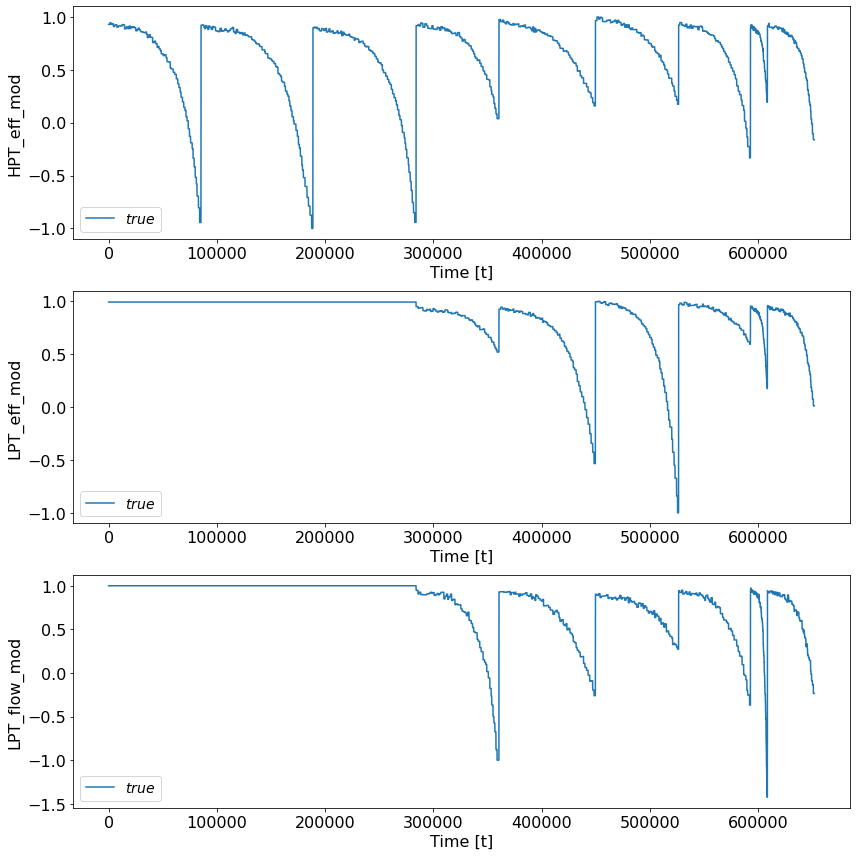

In [ ]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[-3:]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
data[0]['option'] = 'Save'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = np.concatenate((T_train, T_test))
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

In [ ]:
mask = np.concatenate((U_train, U_test)).ravel()
df = DataFrame(data=np.concatenate((W_train, W_test)), columns=varname[0:4])

df1 = df.loc[mask == 2]
df1.reset_index(inplace=True, drop=True)
df2 = df.loc[mask == 5]
df2.reset_index(inplace=True, drop=True)
df3 = df.loc[mask == 10]
df3.reset_index(inplace=True, drop=True)
df4 = df.loc[mask == 16]
df4.reset_index(inplace=True, drop=True)
df5 = df.loc[mask == 18]
df5.reset_index(inplace=True, drop=True)
df6 = df.loc[mask == 20]
df6.reset_index(inplace=True, drop=True)
df7 = df.loc[mask == 11]
df7.reset_index(inplace=True, drop=True)
df8 = df.loc[mask == 14]
df8.reset_index(inplace=True, drop=True)
df9 = df.loc[mask == 15]
df9.reset_index(inplace=True, drop=True)

<Figure size 432x288 with 0 Axes>

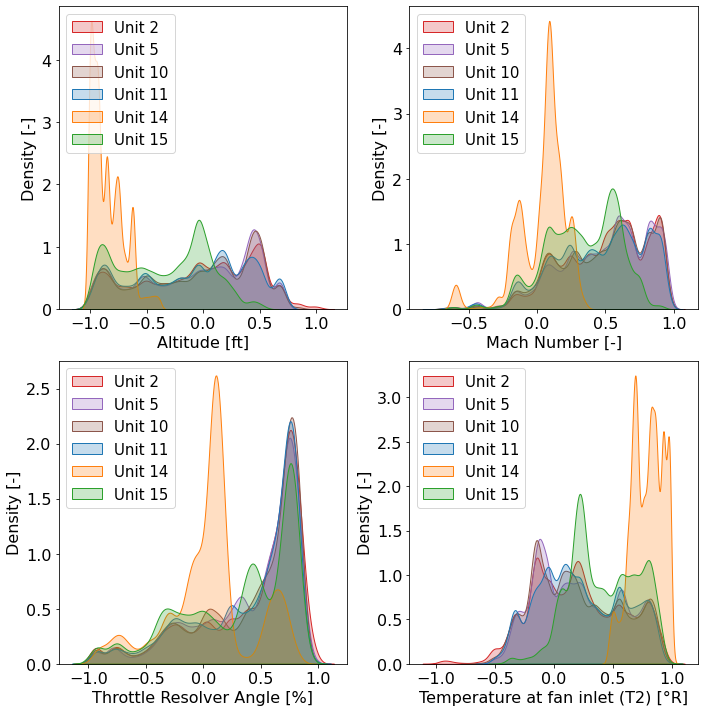

In [ ]:
leg = ['Unit 2', 'Unit 5', 'Unit 10', 'Unit 11','Unit 14','Unit 15']
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
size = 10
plot_kdeplot(leg, variables, labels, size, df1, df2, df3, df7,df8,df9)


#leg = ['Unit 2', 'Unit 5', 'Unit 10', 'Unit 14']
#variables = ['alt', 'Mach', 'TRA', 'T2']
#labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#size = 10
#plot_kdeplot(leg, variables, labels, size, df1, df2, df3, df8)

<Figure size 432x288 with 0 Axes>

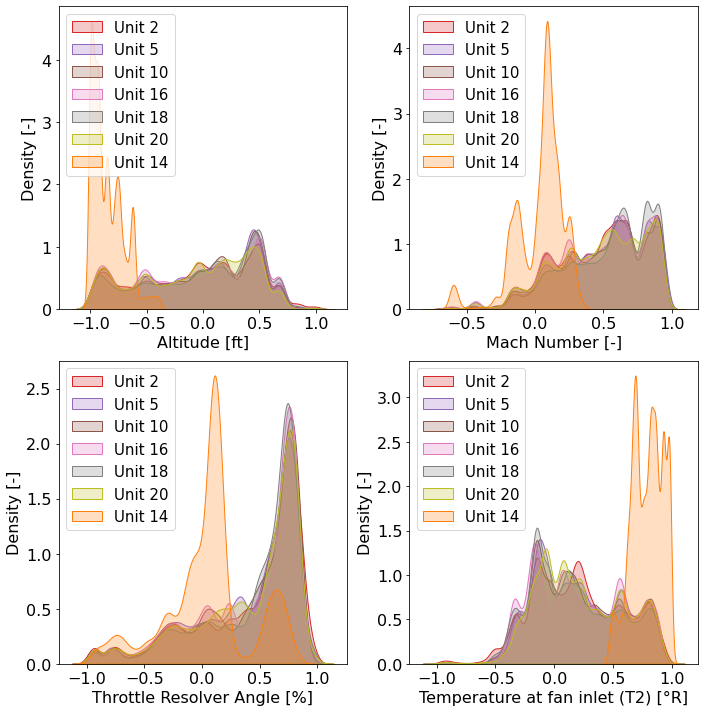

In [ ]:
leg = ['Unit 2', 'Unit 5', 'Unit 10', 'Unit 16', 'Unit 18', 'Unit 20', 'Unit 14']
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
size = 10
plot_kdeplot(leg, variables, labels, size, df1, df2, df3, df4,  df5, df6, df8)

<Figure size 432x288 with 0 Axes>

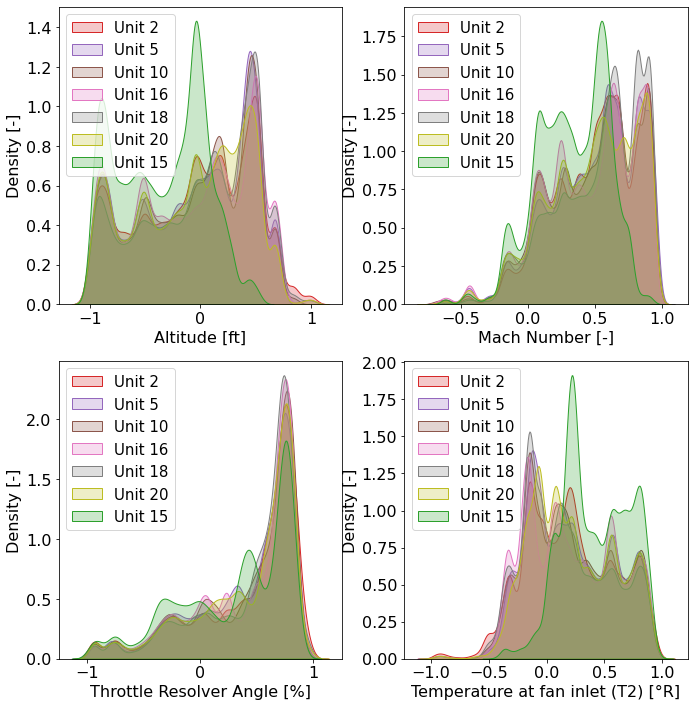

In [ ]:
leg = ['Unit 2', 'Unit 5', 'Unit 10', 'Unit 16', 'Unit 18', 'Unit 20', 'Unit 15']
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
size = 10
plot_kdeplot(leg, variables, labels, size, df1, df2, df3, df4,  df5, df6, df9)

## Part 1 - Pure Data-Driven Prognostics Model with Supervised Learning (SL) 

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json

def create_supervised(input_shape, output_shape, sequence_length, activ, n_hl, n_ch, n_fc, n_k, dropout, seed=229): 
    """
    """    
    # Set-up
    n_cnn = n_hl-1
    channels = [n_ch for i in range(n_cnn)]
    channels[-1] = 1
    kernels = [n_k for i in range(n_cnn)]
    
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = tf.keras.Input(shape=(sequence_length, input_shape)) 
    X = X_input
    
    # Hidden layers
    for i in range(n_cnn):
        X = tf.keras.layers.Conv1D(channels[i],
                                   kernels[i],
                                   strides=1,
                                   padding='same',
                                   activation=activ,
                                   kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed))(X) 

    # Flaten layer
    X = tf.keras.layers.Flatten()(X)
    
    # Dropout layer
    if dropout != 0.0:
        X = tf.keras.layers.Dropout(dropout)(X)
    
    # Hidden Fully connected
    X = tf.keras.layers.Dense(n_fc,
                              activation=activ, 
                              kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed), name='fc')(X)
    
    # Output layer
    X = tf.keras.layers.Dense(output_shape,
                              kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed), name='RUL')(X)

    # Create model
    supervised = tf.keras.Model(inputs=X_input, outputs=X, name='CNN')
       
    # Optimisation 
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

    # Compilation
    supervised.compile(loss=tf.losses.MeanSquaredError(), optimizer=opt)  
       
    return supervised


def train_supervised(OUTFOLDER, 
                     X_train, Y_train, dataset_dev, X_test, Y_test, dataset_test,
                     activ, n_hl, n_ch, n_fc, n_k, batch_size, dropout, epochs, sequence_length,
                     label, generate=True, fit_generator=True, seed=229):
    """
    """
               
    # Set-up I
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    tf.keras.backend.clear_session()

    if fit_generator:
        # Shuffle train dataset
        dataset_size = dataset_dev.cardinality().numpy()
        #dataset_train = dataset_train.shuffle(buffer_size=int(dataset_size.numpy()/4), seed=seed)
        #dataset_dev = dataset_dev.shuffle(buffer_size=dataset_size, seed=seed)#reshuffle_each_iteration=False
        dataset_dev = dataset_dev.shuffle(buffer_size=int(dataset_size/4), seed=seed)#reshuffle_each_iteration=False
        
        # Train / Val split
        train_ds_size = int(0.9*dataset_size)
        dataset_train = dataset_dev.take(train_ds_size)
        dataset_val = dataset_dev.skip(train_ds_size)

        # Create batches
        dataset_train = dataset_train.batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)
        dataset_val = dataset_val.batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)
        dataset_test = dataset_test.batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)
           
    if generate:        
        # Set-up II
        input_shape = X_test.shape[-1]
        output_shape = Y_test.shape[-1]
        
        # Create model   
        supervised = create_supervised(input_shape, output_shape, sequence_length,
                                       activ, n_hl, n_ch, n_fc, n_k, dropout, seed)  
    
        # Report model summary (before fit)
        supervised.summary()    
        tf.keras.utils.plot_model(supervised)
        
        # Check point      
        checkpoint_path = OUTFOLDER + 'training' +  str(label) + '/cp-{epoch:04d}.ckpt'
        checkpoint_dir = os.path.dirname(checkpoint_path)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_best_only=True)
    

        # Early Stopping
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
        
        # Callbacks
        callbacks = [cp_callback, es_callback]
        callbacks = [cp_callback]
    
        # Fit model
        if fit_generator:  
            history = supervised.fit(dataset_train,
                                     epochs=epochs,
                                     validation_data=dataset_val,
                                     #callbacks=callbacks,
                                     verbose=1)
        else:
            history = supervised.fit(X_train, Y_train, 
                                     epochs=epochs,
                                     batch_size=batch_size,
                                     callbacks=callbacks,
                                     validation_split=0.1,
                                     verbose=1)
        # Plot training
        plt.clf()
        plt.figure()
        plt.plot(np.sqrt(history.history['loss']))
        plt.plot(np.sqrt(history.history['val_loss']))
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(OUTFOLDER + 'history' + '_model_' + str(label) + '.png')
        plt.show()
    
        # Save model
        model_json = supervised.to_json()
        with open(OUTFOLDER + 'model_' + str(label) + '.json', "w") as json_file:
            json_file.write(model_json)
        supervised.save_weights(OUTFOLDER + 'model_' + str(label) + '.h5')
        print('')
        print("Saved model to disk")
    
    else:
        # Load supervised model
        with open(OUTFOLDER + 'model_' + str(label) + '.json', "r") as json_file:
            loaded_model_json = json_file.read()
        supervised = model_from_json(loaded_model_json)
        supervised.load_weights(OUTFOLDER + 'model_' + str(label) + '.h5')
        print('')
        print("Loaded supervised model from disk")
        
        # Report model summary
        supervised.summary()

        # Compilation
        supervised.compile(loss=tf.losses.MeanSquaredError())  
    
    # Evaluate and collect outputs
    if fit_generator:  
        # Evaluate model i.e. RMS
        predsTr = supervised.evaluate(dataset_train)
        predsVa = supervised.evaluate(dataset_val)
        predsTs = supervised.evaluate(dataset_test)

        # Predict
        y_hat_train = supervised.predict(dataset_train)
        y_hat_test = supervised.predict(dataset_test)         
    else:
        # Evaluate model i.e. RMS
        predsTr = supervised.evaluate(x=X_train, y=Y_train)
        predsVa = supervised.evaluate(x=X_test, y=Y_test)
        predsTs = supervised.evaluate(x=X_test, y=Y_test)

        # Predict
        y_hat_train = supervised.predict(x=X_train)
        y_hat_test = supervised.predict(x=X_test)

    return predsTs, predsTr, predsVa, y_hat_train, y_hat_test


def grid_search(MODEL_PATH, 
                X_train, Y_train, dataset_train, X_test, Y_test, dataset_test, Y_test_sl, 
                hypco, sequence_length, n_runs, varInput, 
                df, generate=True, fit_generator=True, seed=229):
    """
    """
    # Set-up
    log_Y_hat_train, log_Y_hat_test, log_rmse_test, log_label = [], [], [], []
    
    for ii in range(len(hyp)):         # Varing architectures - hyperparamenters  
        for jj in range(n_runs):       # Check reproducibility - n runs             
            
            # Simulation label
            label =  varInput + '_h_' + str(ii) +  '_run_' + str(jj)
            print('')
            print('Simulation:', label)
            
            # Hyperparameters in loop ii
            activ, n_hl, n_ch, n_fc, n_k, batch_size, dropout, epochs = hyp[ii]
            
            # Train NN model
            time_start = time.perf_counter()            
            predsTs, predsTr, predsVa, Y_hat_train, Y_hat_test = \
            train_supervised(MODEL_PATH,
                             X_train, Y_train, dataset_train, X_test, Y_test, dataset_test,
                             activ, n_hl, n_ch, n_fc, n_k, batch_size, dropout, epochs, sequence_length,
                             label, generate=generate, fit_generator=fit_generator, seed=seed+jj)

            # Store results
            log_Y_hat_train.append(Y_hat_train)
            log_Y_hat_test.append(Y_hat_test)
            log_rmse_test.append(np.sqrt(predsTs))
            log_label.append(label)
            
            # Compute evaluation metrics
            rmse_test = np.round(np.sqrt(predsTs), 3)
            rmse_train = np.round(np.sqrt(predsTr), 3)
            rmse_val = np.round(np.sqrt(predsVa), 3)
            s = np.round(score_cal(Y_hat_test, Y_test_sl), 2)
            time_train = np.round((time.perf_counter()-time_start)/60, 2)        
            
            # Global log of results
            df = df.append({'run': jj, 'input': varInput,
                            'activ': activ, 'n_hl': n_hl, 'n_ch': n_ch, 'n_fc': n_fc, 'n_k': n_k, 
                            'batch': batch_size, 'dropout': dropout, 'epochs': epochs, 'seq_lgh': sequence_length,
                            'RMSE-Ts': rmse_test, 'RMSE-Tr': rmse_train, 'RMSE-Va': rmse_val,
                            's[-]':s , 'Time[min]': time_train}, ignore_index=True)
            print('')
            print(df.to_string())

            # Write solutions to 
            df.to_csv(MODEL_PATH + 'Training_RUL_' +  varInput + '.csv')
            
    # Select model with best rmse
    mask = np.ravel(log_rmse_test==min(log_rmse_test))
    label_best = list(itertools.compress(log_label, mask))[0]

    return log_Y_hat_train, log_Y_hat_test, df, label_best


def predict_rul(MODEL_PATH, label, X):
    """
    Given a model (i.e., model_path+ label) and input X it predicts the model output
    """
    model_sel = MODEL_PATH  + 'model_' + str(label)
    with open(model_sel + '.json', "r") as json_file:
        loaded_model_json = json_file.read()
    rul_model = model_from_json(loaded_model_json)
    rul_model.load_weights(model_sel + '.h5')
    print('')
    print("Loaded RUL model from disk")

    # Predict
    rul_hat = rul_model.predict(X)
                       
    return rul_hat, rul_model


### a) Prognostics based on Condition Monitoring Data

In [ ]:
ROOT_PATH = '03-SL-1dCNN'
MODEL_PATH = ROOT_PATH  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
#MODEL_PATH = ROOT_PATH  + '/DS02_2020-09-30_epoch_30/'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [ ]:
# NN architecture
activ0 = ['relu']            # Activation - h1 = ['tanh', 'relu']
n_hl0 = [4]                  # Number of hidden layers - h2 = [2, 3, 4]
n_ch0 = [20]                 # Number of channels per hidden layer (the same for all) - h3 = [32, 42, 52]
n_fc0 = [50]                 # Number of neurons in fully connected layer - h4 = [50, 100, 200]
n_k0 = [10]                  # Kernel size (n_k0 x 1)

# Set-up III - Optimisation settings
batch_size_s0 = [1024]       # Batch size encoder - h5 = [512, 1024, 2048]
dropout0 = [0.0]             # Dropout - h6 = [0.0, 0.1, 0.5]
epochs_s0 = [30]             # Epochs - h7 (on demand)

# Architecture 'prognostics network'
hyp = list(itertools.product(activ0, n_hl0, n_ch0, n_fc0, n_k0, batch_size_s0, dropout0, epochs_s0))

# Number of runs per NN architecture
n_runs = 6

# Set-up
generate = True              # Fit or load model
fit_generator = True         # Data are generator or 
seed = 229                   # Seed number

# Loggers for training
log_hat_train, log_hat_test =  [], []
df = DataFrame({'run': [], 'input':[],
                'activ': [], 'n_hl': [], 'n_ch': [], 'n_fc': [], 'n_k': [], 
                'batch': [], 'dropout': [], 'epochs': [], 'seq_lgh': [],
                'RMSE-Ts': [], 'RMSE-Tr':[], 'RMSE-Va':[], 's[-]': [], 'Time[min]': []})

In [ ]:
# Creates engine subset
#id_en = [5, 16, 20] 
#id_en = [2, 10, 18]
#id_en = [16, 18, 20] 
#T_hat_train_db70 = extract_units_ds(id_en, T_hat_train_db70, U_train) 
#W_train, X_s_train, Y_train, U_train, C_train, T_train = extract_units(id_en, W_train, X_s_train, Y_train, U_train, C_train, T_train)

In [ ]:
# Set-up
X_wxs_train = np.concatenate((W_train, X_s_train),axis=1)
X_wxs_test = np.concatenate((W_test, X_s_test),axis=1)

In [ ]:
X_wxs_train.shape

(526341, 20)

In [ ]:
# Process
time_start = time.perf_counter() 
sequence_length = 50         # Time sequence length
sequence_stride = 1
sampling_rate = 1

# Train/ Dev dataset
dataset_train = slider_fn_3(X_wxs_train, Y_train, U_train, sequence_length=sequence_length, sequence_stride=sequence_stride, sampling_rate=sampling_rate)

# Test dataset
dataset_test = slider_fn_3(X_wxs_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.perf_counter()-time_start))


Time data sliding [s]:  0.46297112299998844


In [ ]:
# Process (time consuming operation 3-5 min)
time_start = time.process_time()
dataset_unit = slider_fn_3(U_test, U_test, U_test, sequence_length=sequence_length)
dataset_cycle = slider_fn_3(C_test, C_test, U_test, sequence_length=sequence_length)
Y_test_sl = from_batchdataset_to_nparray(dataset_test).reshape(-1,1)
U_test_sl = from_batchdataset_to_nparray(dataset_unit).reshape(-1,1) 
C_test_sl = from_batchdataset_to_nparray(dataset_cycle).reshape(-1,1) 
print('')
print('Time operation [min]: ', round((time.process_time()-time_start)/60, 2))

print('')
print('Shape Y_test_sl:', Y_test_sl.shape)

**Train RUL Model**


Simulation: W_X_s_h_0_run_0
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 20)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
_________________________________________________________________
RUL (Dense)                  (None

<Figure size 432x288 with 0 Axes>

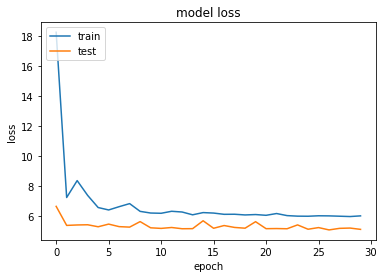


Saved model to disk
123/123 [==============================] - 8s 63ms/step - loss: 25.1378

   run  input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.014    7.289    5.099  0.58     257.74

Simulation: W_X_s_h_0_run_1
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 20)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
__________________________

<Figure size 432x288 with 0 Axes>

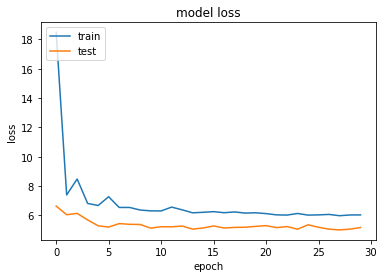


Saved model to disk
123/123 [==============================] - 8s 63ms/step - loss: 23.3543

   run  input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.014    7.289    5.099  0.58     257.74
1  1.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.833    8.343    5.176  0.50     256.64

Simulation: W_X_s_h_0_run_2
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 20)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
____________________________________

<Figure size 432x288 with 0 Axes>

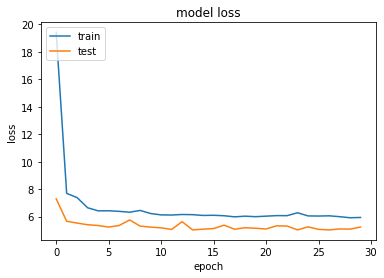


Saved model to disk
123/123 [==============================] - 8s 62ms/step - loss: 33.6072

   run  input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.014    7.289    5.099  0.58     257.74
1  1.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.833    8.343    5.176  0.50     256.64
2  2.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.797    7.970    5.222  0.63     253.70

Simulation: W_X_s_h_0_run_3
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 20)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4020      
______________________________________________

<Figure size 432x288 with 0 Axes>

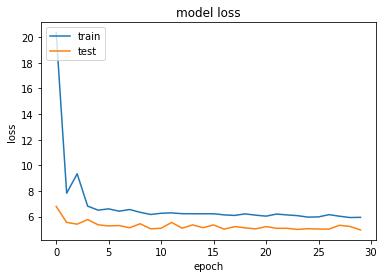


Saved model to disk
123/123 [==============================] - 8s 62ms/step - loss: 23.9389

   run  input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.014    7.289    5.099  0.58     257.74
1  1.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.833    8.343    5.176  0.50     256.64
2  2.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.797    7.970    5.222  0.63     253.70
3  3.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.893    7.625    5.038  0.53     248.55

Simulation: W_X_s_h_0_run_4
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 20)]          0         
________________________________________________________

<Figure size 432x288 with 0 Axes>

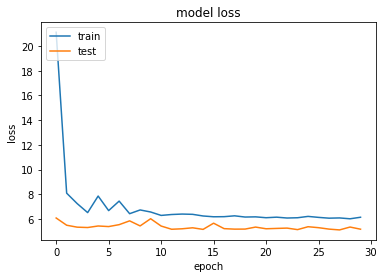


Saved model to disk
123/123 [==============================] - 8s 62ms/step - loss: 22.7080

   run  input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.014    7.289    5.099  0.58     257.74
1  1.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.833    8.343    5.176  0.50     256.64
2  2.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.797    7.970    5.222  0.63     253.70
3  3.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.893    7.625    5.038  0.53     248.55
4  4.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.765    7.988    5.155  0.51     249.41

Simulation: W_X_s_h_0_run_5
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


<Figure size 432x288 with 0 Axes>

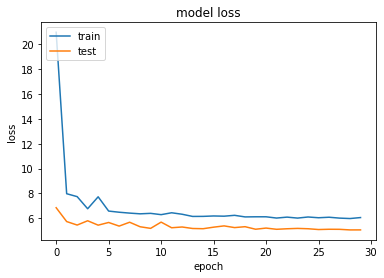


Saved model to disk
123/123 [==============================] - 8s 61ms/step - loss: 22.7486

   run  input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.014    7.289    5.099  0.58     257.74
1  1.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.833    8.343    5.176  0.50     256.64
2  2.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    5.797    7.970    5.222  0.63     253.70
3  3.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.893    7.625    5.038  0.53     248.55
4  4.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.765    7.988    5.155  0.51     249.41
5  5.0  W_X_s  relu   4.0  20.0  50.0  10.0  1024.0      0.0    30.0     50.0    4.770    7.774    5.080  0.52     249.00


In [ ]:
# Train model
varInput = 'W_X_s'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH, 
                                         X_wxs_train, Y_train, dataset_train, X_wxs_test, Y_test, dataset_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

**Predict RUL**

In [ ]:
# Predict rul
Y_hat_test, rul_model = predict_rul(MODEL_PATH, label, dataset_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())


Loaded RUL model from disk

Mean
   Unit 11  Unit 14  Unit 15
0     27.0     28.0     10.0
1     29.0     28.0      9.0
2     23.0     28.0      9.0
3     29.0     37.0      8.0
4     27.0     58.0     10.0
5     27.0     28.0     14.0

Max-Min
   Unit 11  Unit 14  Unit 15
0     48.0     61.0     37.0
1     47.0     58.0     46.0
2     57.0     65.0     59.0
3     41.0     58.0     41.0
4     57.0     65.0     48.0
5     57.0     65.0     59.0

95% Confidence
   Unit 11  Unit 14  Unit 15
0     48.0     61.0     37.0
1     47.0     58.0     46.0
2     57.0     65.0     59.0
3     41.0     58.0     41.0
4     57.0     65.0     48.0
5     57.0     65.0     59.0


**Evaluate RUL performance**

In [ ]:
print('')
print('Data-driven: W_X_s')
print(r's:', score_cal(Y_hat_test, Y_test_sl))
print('RMSE:', np.sqrt(np.mean((Y_hat_test - Y_test_sl)**2)))


Data-driven: W_X_s
s: 0.5259040624417279
RMSE: 4.75268181062882


**Plot predicted Vs. true RUL**

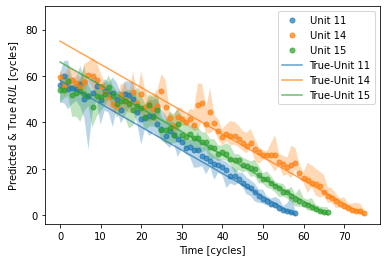

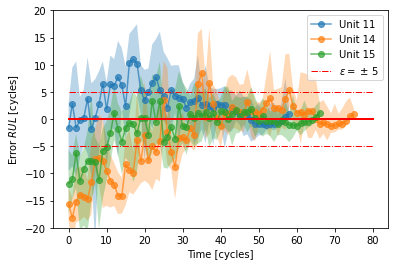

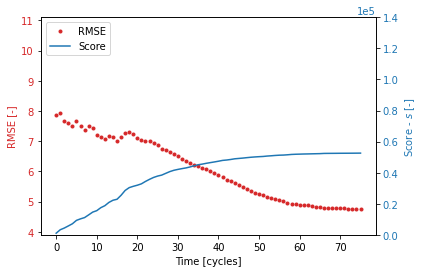

In [ ]:
# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [Y_hat_test], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### b) Impact of Sensor Noise

**Predict RUL**

In [ ]:
# Noisy sensors
X_test_db60 = np.concatenate((W_test, X_s_test_db60), axis=-1)
dataset_test_db60 = slider_fn_3(X_test_db60, Y_test, U_test, sequence_length=sequence_length)
Y_hat_test_db60 = rul_model.predict(dataset_test_db60.batch(1024))

# De-noisy sensors (clean)
X_test_deno = np.concatenate((W_test, X_s_test_deno), axis=-1)
dataset_test_deno = slider_fn_3(X_test_deno, Y_test, U_test, sequence_length=sequence_length)
Y_hat_test_deno = rul_model.predict(dataset_test_deno.batch(1024))

**Evaluate RUL performance**

In [ ]:
print('')
print('Data-driven-Test on noisy data')
print(r's:', score_cal(Y_hat_test_db60, Y_test_sl))
print('RMSE:', np.sqrt(np.mean((Y_hat_test_db60 - Y_test_sl)**2)))

print('')
print('Data-driven-Test on clean data')
print(r's:', score_cal(Y_hat_test_db60, Y_test_sl))
print('RMSE:', np.sqrt(np.mean((Y_hat_test_deno - Y_test_sl)**2)))


Data-driven-Test on noisy data
s: 0.7827140870741368
RMSE: 6.103939802395506

Data-driven-Test on clean data
s: 0.7827140870741368
RMSE: 5.38254740005191


**Plot predicted Vs. true RUL**

In [ ]:
# Plot rul
#unit_sel = [11, 14, 15]
#plot_results(MODEL_PATH, label, [Y_hat_test_db60], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

Unit: 11
Unit: 14
Unit: 15


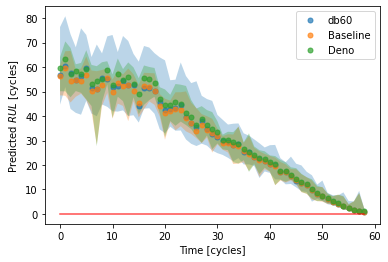

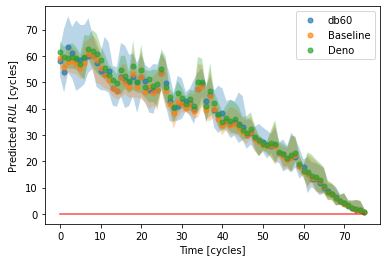

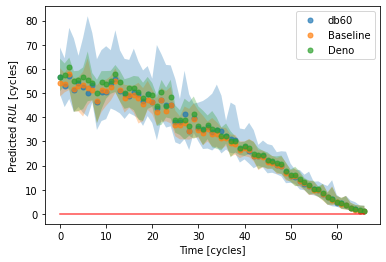

In [ ]:
unit_sel = [11, 14, 15]
log_Y_hat_test = [Y_hat_test_db60, Y_hat_test, Y_hat_test_deno]
leg = ['db60', 'Baseline', 'Deno']
plot_rul_scenarios(unit_sel, log_Y_hat_test, U_test_sl, C_test_sl, leg)

### c) Impact of Sensor Noise (with retraining)

In [ ]:
# Set-up
#X_wxsdb60_train = np.concatenate((W_train, X_s_train_db60),axis=1)
#X_wxsdb60_test = np.concatenate((W_test, X_s_test_db60),axis=1)
#
## Process
#time_start = time.process_time() 
#ds_wxsdb60_train = slider_fn_3(X_wxsdb60_train, Y_train, U_train, sequence_length=sequence_length)
#ds_wxsdb60_test = slider_fn_3(X_wxsdb60_test, Y_test, U_test, sequence_length=sequence_length)
#print('')
#print('Time data sliding [s]: ', (time.process_time()-time_start))
#
## Train model
#varInput = 'W_X_s_db60'
#log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
#                                         X_wxsdb60_train, Y_train, ds_wxsdb60_train, X_wxsdb60_test, Y_test, ds_wxsdb60_test,
#                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
#                                         df, generate=generate, fit_generator=fit_generator, seed=seed)
#
## Predict rul
#rul_hat, rul_model = predict_rul(MODEL_PATH, label, ds_wxsdb60_test.batch(1024))
#
## Predict time
#unit_sel = [11, 14, 15]
#df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
#                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
#print('')
#print('Mean')
#print(df_results.to_string())
#print('')
#print('Max-Min')
#print(df_results_m.to_string())
#print('')
#print('95% Confidence')
#print(df_results_m.to_string())
#
## Plot rul
#unit_sel = [11, 14, 15]
#plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

## Part 2: Fusing Physics and Deep Learning Models for Prognostic

### a)  Impact of De-noised of Sensor Readings -$x_s$


Time data sliding [min]:  0.007537513783336181

Simulation: W_X_s_X_s_deno_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 36)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            7220      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
________

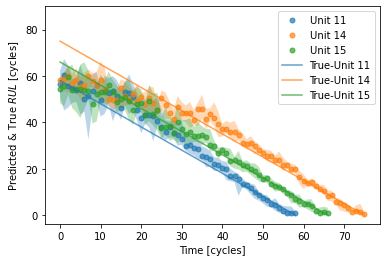

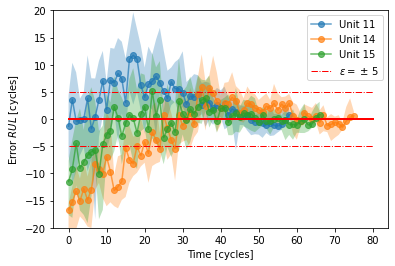

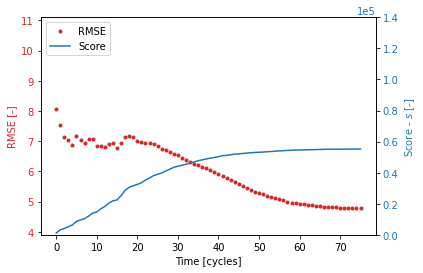

In [ ]:
# Set-up
X_ext_a_train = np.concatenate((W_train, X_s_train, X_s_train_deno),axis=1)
X_ext_a_test = np.concatenate((W_test, X_s_test, X_s_test_deno),axis=1)

# Process
time_start = time.process_time() 
dataset_a_train = slider_fn_3(X_ext_a_train, Y_train, U_train, sequence_length=sequence_length)
dataset_a_test = slider_fn_3(X_ext_a_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [min]: ', (time.process_time()-time_start)/60)

# Train model
varInput = 'W_X_s_X_s_deno'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_a_train, Y_train, dataset_a_train, X_ext_a_test, Y_test, dataset_a_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_a_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### (b)  Impact of Virtual Sensors -$x_v$


Time data sliding [s]:  0.4384192279999297

Simulation: W_X_s_X_s_deno_X_v_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 47)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            9420      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
________

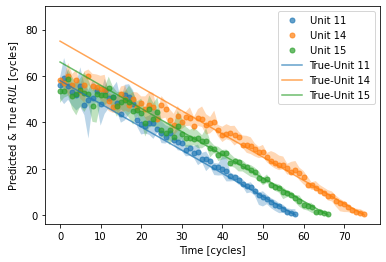

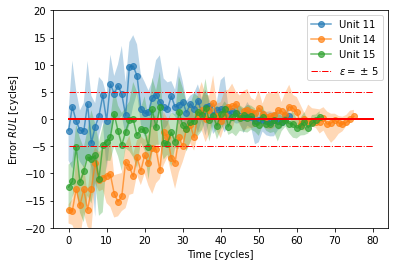

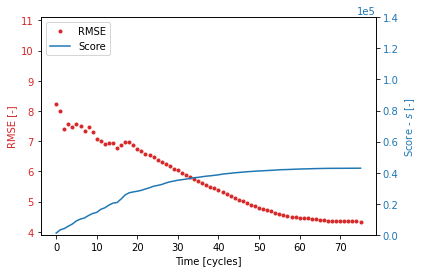

In [ ]:
# Set-up
X_ext_b_train = np.concatenate((W_train, X_s_train, X_s_train_deno, X_v_train),axis=1)
X_ext_b_test = np.concatenate((W_test, X_s_test, X_s_test_deno, X_v_test),axis=1)

# Process
time_start = time.process_time() 
dataset_b_train = slider_fn_3(X_ext_b_train, Y_train, U_train, sequence_length=sequence_length)
dataset_b_test = slider_fn_3(X_ext_b_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_X_s_deno_X_v'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_b_train, Y_train, dataset_b_train, X_ext_b_test, Y_test, dataset_b_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_b_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### (c)  Impact of Calibration Factors - $\theta$ 


Time data sliding [s]:  0.42728754700056015

Simulation: W_X_s_X_s_deno_X_v_T_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            10020     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
_____

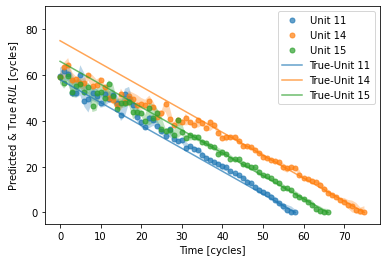

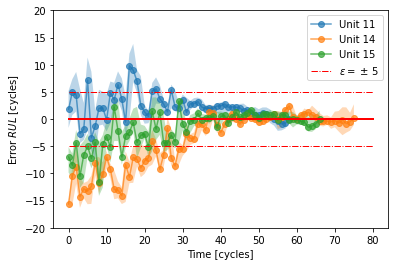

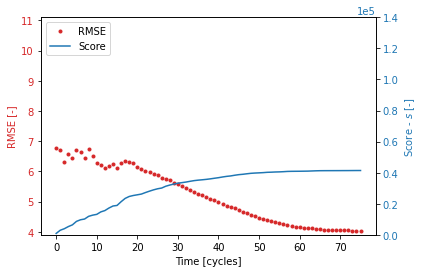

In [ ]:
# Set-up
X_ext_c_train = np.concatenate((W_train, X_s_train, X_s_train_deno, X_v_train, T_train),axis=1)
X_ext_c_test = np.concatenate((W_test, X_s_test, X_s_test_deno, X_v_test, T_test),axis=1)

# Process
time_start = time.process_time() 
dataset_c_train = slider_fn_3(X_ext_c_train, Y_train, U_train, sequence_length=sequence_length)
dataset_c_test = slider_fn_3(X_ext_c_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_X_s_deno_X_v_T'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH, 
                                         X_ext_c_train, Y_train, dataset_c_train, X_ext_c_test, Y_test, dataset_c_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_c_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### Compute amount of mutual information 

In [ ]:
from sklearn.feature_selection import mutual_info_regression

time_start = time.process_time() 
mi = mutual_info_regression(X_ext_c_test, Y_test.ravel())
print('')
print('Time MI computation [m]: ', (time.process_time()-time_start)/60)


Time MI computation [m]:  5.221374210533335


In [ ]:
varname = ['alt', 'Mach', 'TRA', 'T2',
           'T24', 'T30', 'T40', 'T48', 'T50', 
           'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
           'Nf', 'Nc', 'Wf',
           'T24_d', 'T30_d', 'T40_d', 'T48_d', 'T50_d', 
           'P15_d', 'P2_d', 'P21_d', 'P24_d', 'Ps30_d', 'P30_d', 'P40_d', 'P50_d',
           'Nf_d', 'Nc_d', 'Wf_d',
           'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50',
           'SmFan', 'SmLPC', 'SmHPC', 
           'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

In [ ]:
# Process
mi /= np.max(mi)

idx  = [i for i in range(np.shape(mi)[0]) if mi[i] > 0.159]
print('')
print('Indices:', idx)
idx = [0, 1, 2, 3, 26, 32, 47, 48, 49]

labels = [varname[i] for i in np.unique(idx)]
print('')
print(labels)

print('Top-', len(np.unique(idx)))


Indices: [0, 1, 2, 3, 10, 26, 32, 47, 48, 49]

['alt', 'Mach', 'TRA', 'T2', 'P2_d', 'P50_d', 'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']
Top- 9


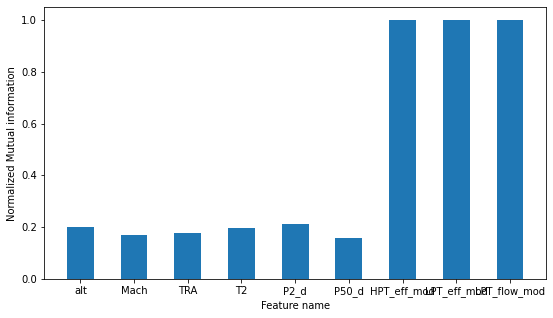

In [ ]:
# Plot MI
values = list(mi[idx])
   
fig = plt.figure(figsize = (9, 5)) 
  
# creating the bar plot 
plt.bar(labels, values, width = 0.5) 
  
plt.xlabel("Feature name") 
plt.ylabel("Normalized Mutual information") 
plt.show() 

### (d)   Impact of -$x_v$


Time data sliding [s]:  0.3739484759998959

Simulation: W_X_s_X_v_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 31)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            6220      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
_________________

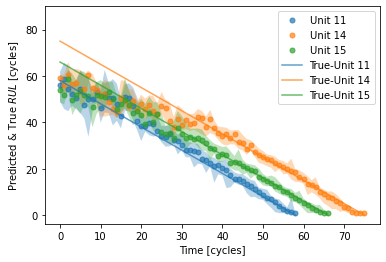

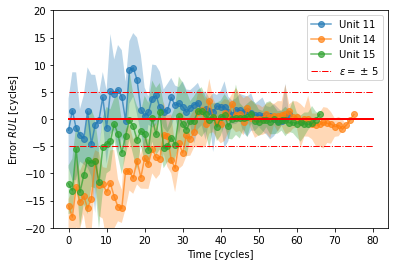

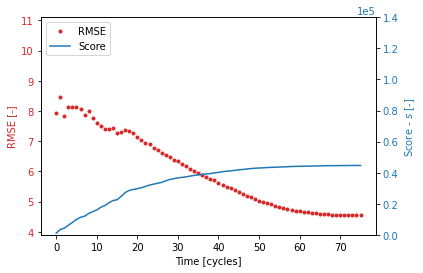

In [ ]:
# Set-up
X_ext_d_train = np.concatenate((W_train, X_s_train, X_v_train),axis=1)
X_ext_d_test = np.concatenate((W_test, X_s_test, X_v_test),axis=1)

# Process
time_start = time.process_time() 
dataset_d_train = slider_fn_3(X_ext_d_train, Y_train, U_train, sequence_length=sequence_length)
dataset_d_test = slider_fn_3(X_ext_d_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train
varInput = 'W_X_s_X_v'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH, 
                                         X_ext_d_train, Y_train, dataset_d_train, X_ext_d_test, Y_test, dataset_d_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_d_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### e) Impact of $\theta$


Time data sliding [s]:  0.38862446599887335

Simulation: W_X_s_T_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
__________________

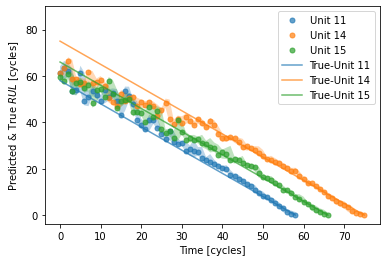

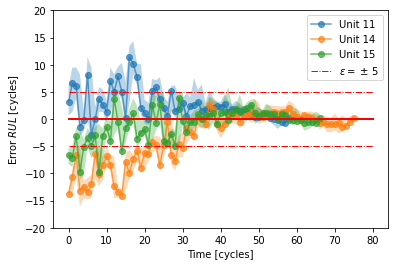

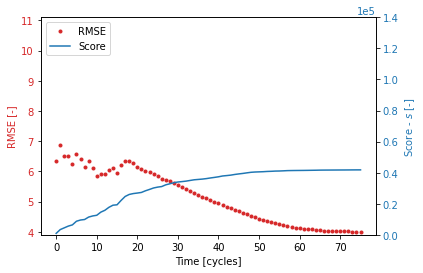

In [ ]:
# Set-up
X_ext_e_train = np.concatenate((W_train, X_s_train, T_train),axis=1)
X_ext_e_test = np.concatenate((W_test, X_s_test, T_test),axis=1)

# Process
time_start = time.process_time() 
dataset_e_train = slider_fn_3(X_ext_e_train, Y_train, U_train, sequence_length=sequence_length, sequence_stride=sequence_stride,sampling_rate=sampling_rate)
dataset_e_test = slider_fn_3(X_ext_e_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train
varInput = 'W_X_s_T'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_e_train, Y_train, dataset_e_train, X_ext_e_test, Y_test, dataset_e_test,
                                         Y_test_sl, hyp, sequence_length, 4, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)
# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_e_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

In [ ]:
## Set-up
#X_ext_e_train = np.concatenate((W_train, X_s_train, T_hat_train_db70), axis=1)
#X_ext_e_test = np.concatenate((W_test, X_s_test, T_hat_test_db70), axis=1)
#
## Process
#time_start = time.process_time() 
#dataset_e_train = slider_fn_3(X_ext_e_train, Y_train, U_train, sequence_length=sequence_length, sequence_stride=sequence_stride,sampling_rate=sampling_rate)
#dataset_e_test = slider_fn_3(X_ext_e_test, Y_test, U_test, sequence_length=sequence_length)
#print('')
#print('Time data sliding [s]: ', (time.process_time()-time_start))
#
## Train
#varInput = 'W_X_s_T_hat'
#log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
#                                         X_ext_e_train, Y_train, dataset_e_train, X_ext_e_test, Y_test, dataset_e_test,
#                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
#                                         df, generate=generate, fit_generator=fit_generator, seed=seed)
## Predict rul
#rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_e_test.batch(1024))
#
## Predict time
#unit_sel = [11, 14, 15]
#df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
#                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
#print('')
#print('Mean')
#print(df_results.to_string())
#print('')
#print('Max-Min')
#print(df_results_m.to_string())
#print('')
#print('95% Confidence')
#print(df_results_m.to_string())
#
## Plot rul
#unit_sel = [11, 14, 15]
#plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

## Part 3: Prognostics with uncertain model calibration

###  Impact of  $\theta$ bias

In [ ]:
# Nominal theta
X_test_path_1 = np.concatenate((W_test, X_s_test, T_test), axis=-1)
dataset_test_path_1 = slider_fn_3(X_test_path_1, Y_test, U_test, sequence_length=sequence_length)
rul_path_1 = rul_model.predict(dataset_test_path_1.batch(1024))

# High theta
X_test_path_2 = np.concatenate((W_test, X_s_test, T_path2_test), axis=-1)
dataset_test_path_2 = slider_fn_3(X_test_path_2, Y_test, U_test, sequence_length=sequence_length)
rul_path_2 = rul_model.predict(dataset_test_path_2.batch(1024))

#Low theta
X_test_path_3 = np.concatenate((W_test, X_s_test, T_path3_test), axis=-1)
dataset_test_path_3 = slider_fn_3(X_test_path_3, Y_test, U_test, sequence_length=sequence_length)
rul_path_3 = rul_model.predict(dataset_test_path_3.batch(1024))

In [ ]:
print('')
print('Bias - Up')
print(r's:',score_cal(rul_path_2, Y_test_sl))
print('RMSE:', np.sqrt(np.mean((rul_path_2 - Y_test_sl)**2)))

print('')
print('Bias - Down')
print(r's:', score_cal(rul_path_3, Y_test_sl))
print('RMSE:', np.sqrt(np.mean((rul_path_3 - Y_test_sl)**2)))


Bias - Up
s: 1.7546107182399093
RMSE: 8.966738666368263

Bias - Down
s: 0.6193979552994971
RMSE: 5.524772315127283


Unit: 11
Unit: 14
Unit: 15


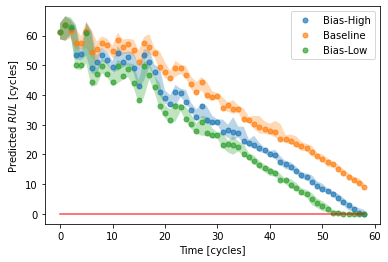

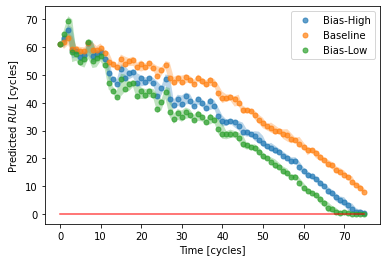

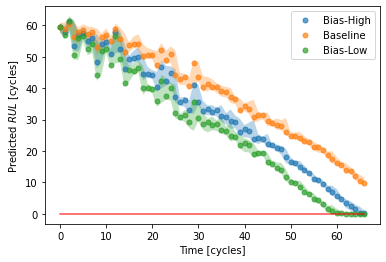

In [ ]:
unit_sel = [11, 14, 15]
log_rul_path_gen  = [rul_path_1, rul_path_2, rul_path_3] 
leg = ['Bias-High', 'Baseline', 'Bias-Low']
plot_rul_scenarios(unit_sel, log_rul_path_gen, U_test_sl, C_test_sl, leg)

###  Impact of  $\theta$ noise

In [ ]:
# db30
X_test_db30 = np.concatenate((W_test, X_s_test, T_test_db30), axis=-1)
dataset_test_db30 = slider_fn_3(X_test_db30, Y_test, U_test, sequence_length=sequence_length)
rul_db30 = rul_model.predict(dataset_test_db30.batch(1024))

# db20
X_test_db20 = np.concatenate((W_test, X_s_test, T_test_db20), axis=-1)
dataset_test_db20 = slider_fn_3(X_test_db20, Y_test, U_test, sequence_length=sequence_length)
rul_db20 = rul_model.predict(dataset_test_db20.batch(1024))

# db10
X_test_db10 = np.concatenate((W_test, X_s_test, T_test_db10), axis=-1)
dataset_test_db10 = slider_fn_3(X_test_db10, Y_test, U_test, sequence_length=sequence_length)
rul_db10 = rul_model.predict(dataset_test_db10.batch(1024))


In [ ]:
for tmp_Y_hat in log_rul_path_gen:
    print('')
    print(r's:', score_cal(tmp_Y_hat, Y_test_sl))
    print('RMSE:', np.sqrt(np.mean((tmp_Y_hat  - Y_test_sl)**2)))


s: 0.41804402989301837
RMSE: 3.9967378321150395

s: 1.7546107182399093
RMSE: 8.966738666368263

s: 0.6193979552994971
RMSE: 5.524772315127283


Unit: 11
Unit: 14
Unit: 15


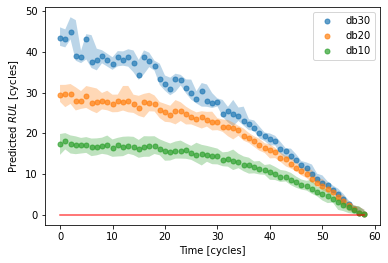

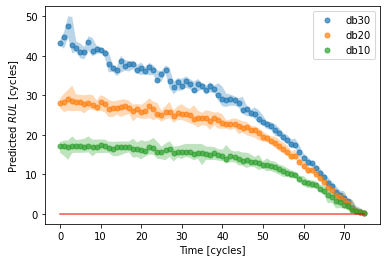

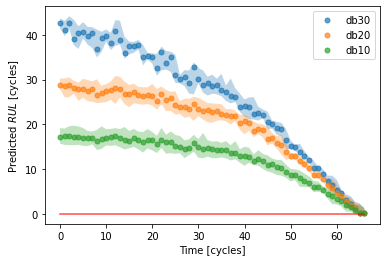

In [ ]:
unit_sel = [11, 14, 15]
log_rul_path_gen  = [rul_db30, rul_db20, rul_db10] 
leg = ['db30', 'db20', 'db10']
plot_rul_scenarios(unit_sel, log_rul_path_gen, U_test_sl, C_test_sl, leg)

### f) Impact of $\theta$ bias - Up - (with retraining)


Time data sliding [s]:  0.38245174000076076

Simulation: W_X_s_T_path2_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
____________

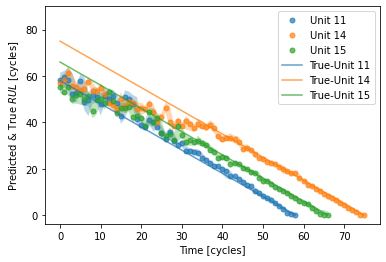

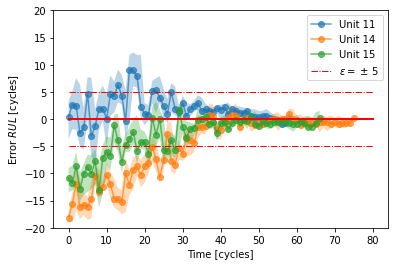

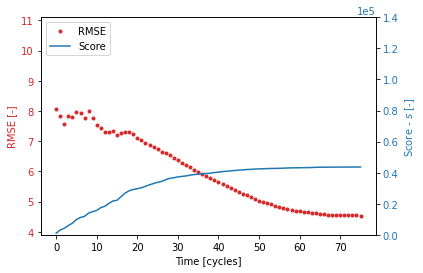

In [ ]:
# Set-up
X_ext_f_train = np.concatenate((W_train, X_s_train, T_path2_train),axis=1)
X_ext_f_test = np.concatenate((W_test, X_s_test, T_path2_test),axis=1)

# Process
time_start = time.process_time() 
dataset_f_train = slider_fn_3(X_ext_f_train, Y_train, U_train, sequence_length=sequence_length)
dataset_f_test = slider_fn_3(X_ext_f_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_T_path2'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_f_train, Y_train, dataset_f_train, X_ext_f_test, Y_test, dataset_f_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_f_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())


# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### g) Impact of $\theta$ bias - Down - (with retraining)

In [ ]:
# Set-up
X_ext_g_train = np.concatenate((W_train, X_s_train, T_path3_train),axis=1)
X_ext_g_test = np.concatenate((W_test, X_s_test, T_path3_test),axis=1)

# Process
time_start = time.process_time() 
dataset_g_train = slider_fn_3(X_ext_g_train, Y_train, U_train, sequence_length=sequence_length)
dataset_g_test = slider_fn_3(X_ext_g_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_T_path3'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_g_train, Y_train, dataset_g_train, X_ext_g_test, Y_test, dataset_g_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_g_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)


Time data sliding [s]:  0.396257506999973

Simulation: W_X_s_T_path3_h_0_run_0

Loaded supervised model from disk
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
______________

### h) Impact of $\theta$ noise - db30 - (with retraining)

In [ ]:
# Set-up
X_ext_h_train = np.concatenate((W_train, X_s_train, T_train_db30),axis=1)
X_ext_h_test = np.concatenate((W_test, X_s_test, T_test_db30),axis=1)

# Process
time_start = time.process_time() 
dataset_h_train = slider_fn_3(X_ext_h_train, Y_train, U_train, sequence_length=sequence_length)
dataset_h_test = slider_fn_3(X_ext_h_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_T_db30'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_h_train, Y_train, dataset_h_train, X_ext_h_test, Y_test, dataset_h_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_h_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### i) Impact of $\theta$ noise - db20 - (with retraining)

In [ ]:
# Set-up
X_ext_i_train = np.concatenate((W_train, X_s_train, T_train_db30),axis=1)
X_ext_i_test = np.concatenate((W_test, X_s_test, T_test_db30),axis=1)

# Process
time_start = time.process_time() 
dataset_i_train = slider_fn_3(X_ext_i_train, Y_train, U_train, sequence_length=sequence_length)
dataset_i_test = slider_fn_3(X_ext_i_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_T_db20'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_i_train, Y_train, dataset_i_train, X_ext_i_test, Y_test, dataset_i_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_i_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### j) Impact of $\theta$ noise - db10 - (with retraining)

In [ ]:
# Set-up
X_ext_j_train = np.concatenate((W_train, X_s_train, T_train_db10),axis=1)
X_ext_j_test = np.concatenate((W_test, X_s_test, T_test_db10),axis=1)

# Process
time_start = time.process_time() 
dataset_j_train = slider_fn_3(X_ext_j_train, Y_train, U_train, sequence_length=sequence_length)
dataset_j_test = slider_fn_3(X_ext_j_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_T_db10'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_j_train, Y_train, dataset_j_train, X_ext_j_test, Y_test, dataset_j_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_j_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

### j) Impact of $\theta$ noise - db10 - (with retraining)


Time data sliding [s]:  0.5438179689990648

Simulation: W_X_s_T_db10_h_0_run_0
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
fc (Dense)                   (None, 50)                2550      
_________________________________________________

<Figure size 432x288 with 0 Axes>

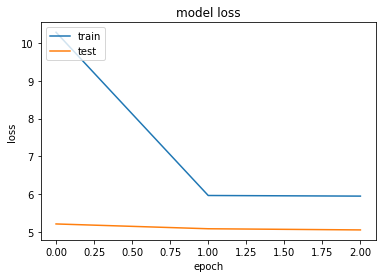


Saved model to disk
123/123 [==============================] - 21s 169ms/step - loss: 25.5682

   run         input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.056    5.917    5.056   0.6      16.84

Simulation: W_X_s_T_db10_h_0_run_1
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             201       
___

<Figure size 432x288 with 0 Axes>

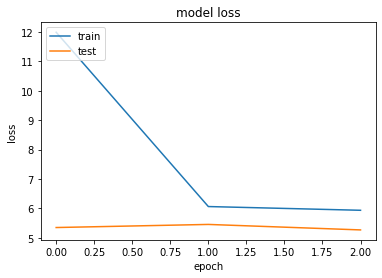


Saved model to disk
123/123 [==============================] - 21s 174ms/step - loss: 27.7331

   run         input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.056    5.917    5.056  0.60      16.84
1  1.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.266    5.960    5.266  0.65      17.04

Simulation: W_X_s_T_db10_h_0_run_2
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            4020      
______

<Figure size 432x288 with 0 Axes>

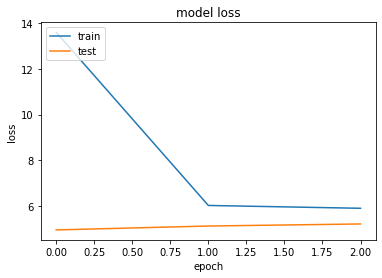


Saved model to disk
123/123 [==============================] - 21s 169ms/step - loss: 27.1854

   run         input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.056    5.917    5.056  0.60      16.84
1  1.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.266    5.960    5.266  0.65      17.04
2  2.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.214    5.919    5.214  0.66      17.18

Simulation: W_X_s_T_db10_h_0_run_3
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            4620      
_________

<Figure size 432x288 with 0 Axes>

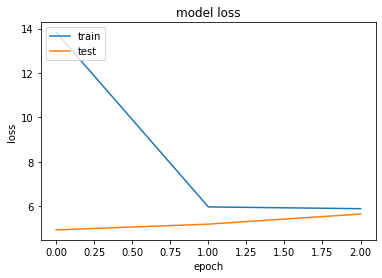


Saved model to disk
123/123 [==============================] - 21s 170ms/step - loss: 31.9681

   run         input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.056    5.917    5.056  0.60      16.84
1  1.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.266    5.960    5.266  0.65      17.04
2  2.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.214    5.919    5.214  0.66      17.18
3  3.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.654    5.823    5.654  0.80      17.06

Simulation: W_X_s_T_db10_h_0_run_4
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 23)]          0         
____________

<Figure size 432x288 with 0 Axes>

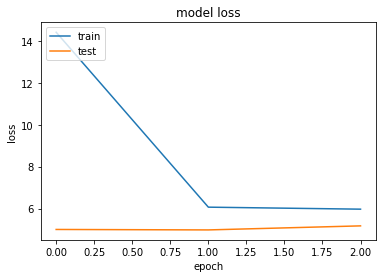


Saved model to disk
123/123 [==============================] - 21s 172ms/step - loss: 26.7758

   run         input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.056    5.917    5.056  0.60      16.84
1  1.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.266    5.960    5.266  0.65      17.04
2  2.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.214    5.919    5.214  0.66      17.18
3  3.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.654    5.823    5.654  0.80      17.06
4  4.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.175    5.943    5.175  0.63      17.15

Simulation: W_X_s_T_db10_h_0_run_5
Model: "CNN"
_________________________________________________________________
Layer (type)   

<Figure size 432x288 with 0 Axes>

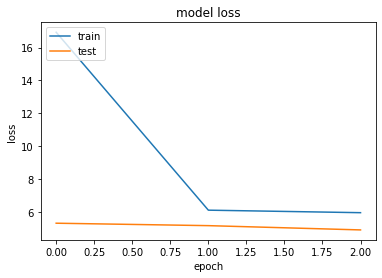


Saved model to disk
123/123 [==============================] - 22s 178ms/step - loss: 24.1313

   run         input activ  n_hl  n_ch  n_fc   n_k   batch  dropout  epochs  seq_lgh  RMSE-Ts  RMSE-Tr  RMSE-Va  s[-]  Time[min]
0  0.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.056    5.917    5.056  0.60      16.84
1  1.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.266    5.960    5.266  0.65      17.04
2  2.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.214    5.919    5.214  0.66      17.18
3  3.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.654    5.823    5.654  0.80      17.06
4  4.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    5.175    5.943    5.175  0.63      17.15
5  5.0  W_X_s_T_db10  relu   4.0  20.0  50.0  10.0  1024.0      0.0     3.0     50.0    4.912    6.129    4.912  0.55      17.11



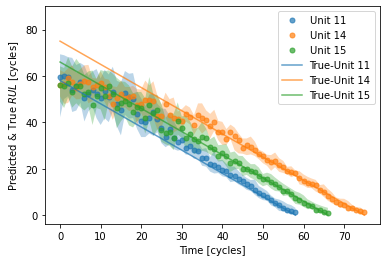

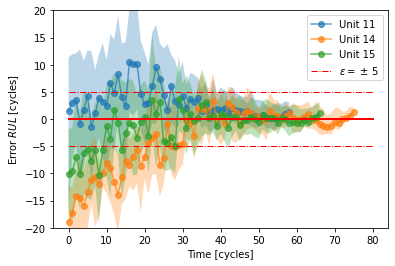

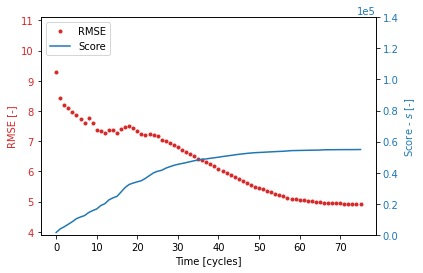

In [ ]:
# Set-up
X_ext_j_train = np.concatenate((W_train, X_s_train, T_train_noise_db10), axis=1)
X_ext_j_test = np.concatenate((W_test, X_s_test, T_test_noise_db10), axis=1)

# Process
time_start = time.process_time() 
dataset_j_train = slider_fn_3(X_ext_j_train, Y_train, U_train, sequence_length=sequence_length)
dataset_j_test = slider_fn_3(X_ext_j_test, Y_test, U_test, sequence_length=sequence_length)
print('')
print('Time data sliding [s]: ', (time.process_time()-time_start))

# Train model
varInput = 'W_X_s_T_db10'
log_hat_train, log_hat_test, df, label = grid_search(MODEL_PATH,
                                         X_ext_j_train, Y_train, dataset_j_train, X_ext_j_test, Y_test, dataset_j_test,
                                         Y_test_sl, hyp, sequence_length, n_runs, varInput,
                                         df, generate=generate, fit_generator=fit_generator, seed=seed)

# Predict rul
rul_hat, rul_model = predict_rul(MODEL_PATH, label, dataset_j_test.batch(1024))

# Predict time
unit_sel = [11, 14, 15]
df_results, df_results_m, df_results_q = predict_time(MODEL_PATH, 
                                                      varInput, log_hat_test, unit_sel, U_test_sl, C_test_sl, max_d=5)
print('')
print('Mean')
print(df_results.to_string())
print('')
print('Max-Min')
print(df_results_m.to_string())
print('')
print('95% Confidence')
print(df_results_m.to_string())

# Plot rul
unit_sel = [11, 14, 15]
plot_results(MODEL_PATH, label, [rul_hat], unit_sel, Y_test_sl, U_test_sl, C_test_sl)

## Summary Simulations


In [ ]:
print("Total simulation time [h]:", round(sum(df['Time[min]'])/60, 2))

In [ ]:
# C:/Users/arimanue/polybox/git/prognostics/models/00-SL-FF/DS02_2020-09-21/_W_X_s_T_db10_Training_RUL.csv
varInput = 'W_X_s_T_db10'
filename = MODEL_PATH +  'Training_RUL_' +  varInput + '.csv'
df = pd.read_csv(filename, sep=',')

print('')
print(df.to_string())

In [ ]:
variables = ['RMSE-Ts', 's[-]']
cases = ['W_X_s', 'W_X_s_db60', 'W_X_s_X_s_deno']
#cases = list(np.unique(df.input))
df_results_mean = DataFrame()
df_results_std = DataFrame()
df_results_val = DataFrame()
df_results = DataFrame()

for i, elem in enumerate(cases): 
    for var in variables:
        df_results_mean.loc[i, 'input'] = elem
        df_results_mean.loc[i, var] = round(np.mean(df[var][df['input']==elem]),2)
        df_results_std.loc[i, 'input'] = elem
        df_results_std.loc[i, var] = round(np.std(df[var][df['input']==elem]),3)
        df_results_val['input'] = elem
        df_results_val[var] = df[var][df['input']==elem].values 
    df_results = df_results.append(df_results_val, sort=True)
    
print('')
print(df_results_mean.to_string())

print('')
print(df_results_std.to_string())

In [ ]:
ax = sns.boxplot(x="input", y="RMSE-Ts", data=df_results)